## 图像金字塔

图像金字塔简单来说就是**用多个不同的尺寸来表示一张图片**。
如下图，最左边的图片是原始图片，然后**从左向右图片的尺寸依次缩小直到图片的尺寸达到一个阈值**，这个阈值就是多次缩小图片的最小尺寸，不会有比这更小尺寸的图片了，像这种图片的尺寸逐步递增或递减的多张图层就是图像金字塔，每张不同尺寸的图片都称为图像金字塔的一层。
图像金字塔的目的就是寻找图片中出现的不同尺寸的目标（物体、动物等）。

![](../dataset/2_pyramid/图像金字塔演示.jpg)

**作用:** 因为滑动窗口的窗口大小是固定的，因此我们需要通过改变图像的大小，来使得窗口可以框住需要的物体。

In [1]:
import cv2
from matplotlib import pyplot as plt
from IPython import display
%matplotlib inline

In [2]:
def pyramid(image, top = (128, 128), ratio = 1.2):
    """生成图像金字塔的图片

    Args:
        image ([type]): 要进行图像金字塔操作的原始图片
        top (tuple, optional): 是图像将会被缩小的最小尺寸，我们将这个参数设置一个默认值为 (128, 128)，第一个 128 表示图片的高，第二个 128 表示图片的宽. Defaults to (128, 128).
        ratio (float, optional): 表示每次图像将会被缩小 ratio 倍，我们给这个参数设置了一个默认值为 1.2. Defaults to 1.2.

    Yields:
        [type]: [description]
    """
    yield image # 返回原始的图像
    
    while True:
        (w, h) = (int(image.shape[1] / ratio), int(image.shape[0] / ratio)) # 新的图像的 宽度 和 长度
        image = cv2.resize(image, (w, h), interpolation = cv2.INTER_AREA) # 调整图像的大小
        
        if w < top[1] or h < top[0]: # 判断图像是否到达最小尺寸
            break
        
        yield image

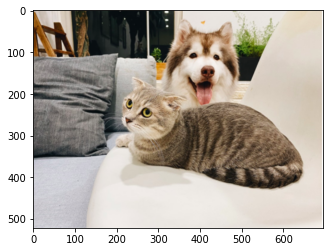

In [3]:
# 使用一张图像进行测试
image = cv2.imread("../dataset/2_pyramid/pets.jpg") # 读取样例图像
plt.imshow(image[:,:,::-1]) # 图像显示

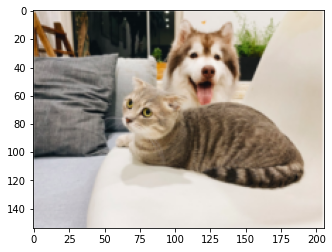

In [5]:
for i in pyramid(image, ratio = 1.5):
    i = i[:,:,::-1] # 展示图像, 查看图片的坐标轴在变小
    plt.imshow(i)
    plt.pause(0.3) 
    display.clear_output(wait=True)

## 图像金字塔结合滑动窗口

在传统的目标检测方法中，使用**图像金字塔**和**滑动窗口**相结合的方式来检测出图片中不同位置和不同尺寸的目标。
使用滑动窗口的方法时，在图片上滑动的**矩形框尺寸是固定的**，这就导致了如果目标的尺寸相对于矩形框太大或太小都会导致我们无法检测到目标。

这种情况下，我们可以在图像金字塔的每层图片上进行滑动窗口的操作来解决这个问题。
如下图左边的图片，狗并不能完全被矩形框包围，矩形框只能包住狗的部分面部区域；
下图右边的图片，通过运用图像金字塔和滑动窗口相结合的方法，**矩形框的尺寸没有变化，但是在经过缩小后的图片中狗完全被矩形框包裹住了**。

![](../dataset/2_pyramid/图像金字塔与滑动窗口例子.jpg)

In [6]:
def sliding_window(image, window, step):
    """用于获取滑动窗口的坐标

    Args:
        image ([type]): 输入的图像
        window ([type]): 滑动窗口的大小, 输入是一组 tuple, 例如 (window_w, window_h)
        step ([type]): 滑动窗口每次移动的步长

    Yields:
        [type]: [description]
    """
    for y in range(0, image.shape[0] - window[1], step): # 控制框上下移动
        for x in range(0, image.shape[1] - window[0], step): # 控制框左右移动
            yield (x, y, image[y:y + window[1], x:x + window[0]]) # 返回框的左上角坐标和图像的截取部分

In [ ]:
# 结合方式: 图像金字塔返回一个图像, 使用滑动窗口进行绘制矩形
(window_w, window_h) = (128, 128) # 滑动窗口的大小

for i in pyramid(image, ratio = 1.5): # 返回一个大小的图像
    for (x, y, window) in sliding_window(i, (window_w, window_h), 100):
        if window.shape[0] != window_w or window.shape[1] != window_h:
            continue
            
        clone = i.copy()
        cv2.rectangle(clone, (x, y), (x + window_w, y + window_h), (0, 255, 0), 2)
        clone = clone[:,:,::-1]
        plt.imshow(clone)
        plt.pause(0.3) 
        display.clear_output(wait=True)

下图就是我们运行脚本后得到的部分图片。可以看到我们在图像金字塔的每一层都使用滑动窗口，虽然矩形框的尺寸保持不变，但是随着图片地不断缩小，矩形框逐渐包裹住目标。

